In [1]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd

from utils import *

## A look at the data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [4]:
(df.Id == 'new_whale').mean()

0.3810575292772367

In [5]:
(df.Id.value_counts() == 1).mean()

0.4141858141858142

41% of all whales have only a single image associated with them.

38% of all images contain a new whale - a whale that has not been identified as one of the known whales.

There is a superb writeup on what a solution to this problem might look like [here](https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/notebook). In general, the conversation in the Kaggle [forum](https://www.kaggle.com/c/humpback-whale-identification/discussion) also seems to have some very informative threads.

Either way, starting with a simple model that can be hacked together in a couple of lines of code is a recommended approach. It is good to have a baseline to build on - going for a complex model from start is a way for dying a thousand deaths by subtle bugs.

In [6]:
df.Id.nunique()

5005

In [7]:
df.shape

(25361, 2)

In [8]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [9]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [10]:
data = (
    ImageItemList
        .from_folder('data/train')
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path.name])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
)

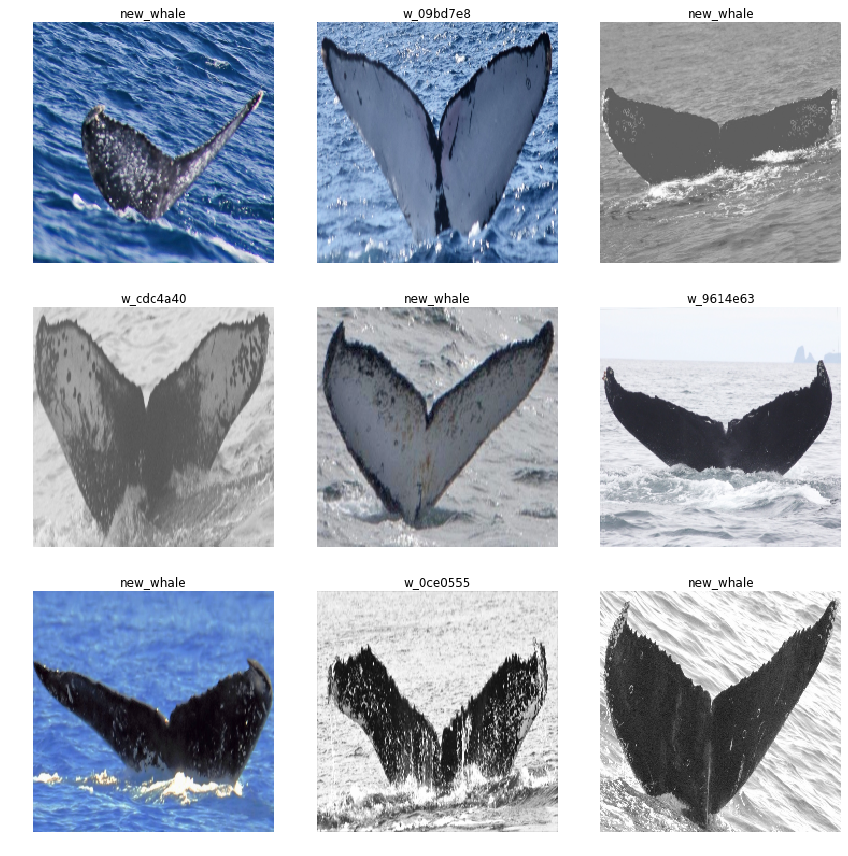

In [11]:
data.show_batch(rows=3)

## Train

In [11]:
name = f'res50-{SZ}'

In [12]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

In [20]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,map5
1,5.719490,4.488849,0.491522,0.515240
2,5.066765,4.216836,0.498028,0.528194


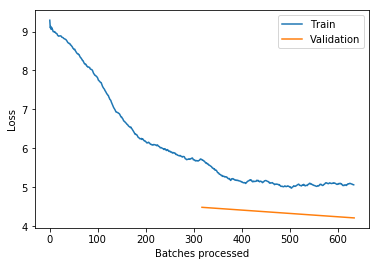

In [21]:
learn.recorder.plot_losses()

In [14]:
learn.save(f'{name}-stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


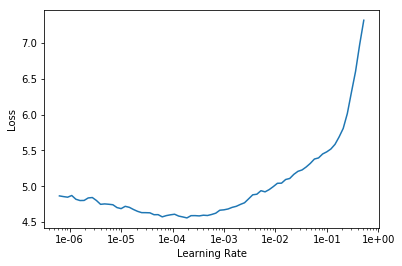

In [18]:
learn.recorder.plot()

In [19]:
max_lr = 1e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [20]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,4.578996,4.182194,0.503549,0.533507
2,4.572483,4.125964,0.508478,0.540145
3,4.352147,4.075052,0.508675,0.542731
4,4.134466,4.056174,0.511435,0.545587
5,4.052724,4.054882,0.511633,0.545853


In [21]:
learn.save(f'{name}-stage-2')

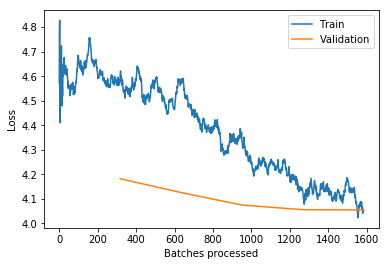

In [36]:
learn.recorder.plot_losses()

This is not a loss plot you would normally expect to see. Why does it look like this? Let's consider what images appear in the validation set:
 * images of whales that do not appear in the train set (whales where all their images were randomly assigned to the validation set) - there is nothing our model can learn about these!
 * images of whales with multiple images in the dataset where some subset of those got assigned to the validation set
 * `new_whale` images
 
Intuitively, a model such as the above does not seem to frame the problem in a way that would be easy for a neural network to solve. Nonetheless, it is interesting to think how we could improve on the construction of the validation set? What tweaks could be made to the model to improve its performance?

## Predict

In [23]:
preds, _ = learn.get_preds(DatasetType.Test)

CPU times: user 11 s, sys: 4.92 s, total: 15.9 s
Wall time: 35.6 s


In [60]:
mkdir -p subs

In [32]:
create_submission(preds, learn.data, name)

In [33]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,47380533f.jpg,new_whale w_3ec7fa2 w_8f4d879 w_15951db w_57acd97
1,1d9de38ba.jpg,new_whale w_0135f5f w_9c506f6 w_2b069ba w_e966f36
2,b3d4ee916.jpg,new_whale w_26c0ffd w_f765256 w_e966f36 w_1b0db58
3,460fd63ae.jpg,new_whale w_4bf625b w_d97c490 w_9b5109b w_e2372d6
4,79738ffc1.jpg,new_whale w_60ce6fc w_08630fd w_7e2eb3d w_6caff0f


In [34]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 126k/126k [00:00<00:00, 63.5kB/s]
Successfully submitted to Humpback Whale Identification